In [11]:
import json
import torch
import numpy as np
from transformers import AdamW
from sklearn.metrics import accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [3]:
file_path = 'qa_dataset.json'

with open(file_path, 'r') as file:
    data = json.load(file)

In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [5]:
# Tokenizing the data
inputs = tokenizer([x['question'] + " [SEP] " + x['answer'] for x in data], padding=True, truncation=True, return_tensors="pt")

# Assuming binary classification (change as needed)
labels = torch.tensor([1 if x['answer_length'] > 100 else 0 for x in data])

# Create a dataset
dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

model = model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
# check GPU is work
# Train the model using a suitable optimizer and loss function.
if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


In [8]:
print(len(dataset))
dataset[:10]

1628


(tensor([[ 101, 2515, 2023,  ...,    0,    0,    0],
         [ 101, 2064, 2017,  ...,    0,    0,    0],
         [ 101, 2054, 2003,  ...,    0,    0,    0],
         ...,
         [ 101, 2064, 2009,  ...,    0,    0,    0],
         [ 101, 7632, 2515,  ...,    0,    0,    0],
         [ 101, 2003, 1996,  ...,    0,    0,    0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([1, 0, 1, 0, 1, 0, 0, 0, 0, 0]))

In [9]:
# Define a directory to save the model
model_save_path = 'models'
os.makedirs(model_save_path, exist_ok=True)

In [10]:
# Parameters
batch_size = 8
epochs = 25

# Prepare for epoch_losses
epoch_losses = []

# Data loader
dataloader = DataLoader(dataset, sampler=RandomSampler(dataset), batch_size=batch_size)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}")

    for batch in progress_bar:
        # b_input_ids, b_input_mask, b_labels = batch
        b_input_ids, b_input_mask, b_labels = batch[0].to(device), batch[1].to(device), batch[2].to(device)
        model.zero_grad()

        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        # Update the progress bar
        progress_bar.set_postfix({'loss': total_loss/len(dataloader)})
        
    # Calculate and store the average loss for this epoch
    avg_loss = total_loss / len(dataloader)
    epoch_losses.append(avg_loss)
    
    # Save the model after each epoch
    model_save_file = os.path.join(model_save_path, f'bert_model_epoch_{epoch+1}.pt')
    torch.save(model.state_dict(), model_save_file)

    # Closing the progress bar and printing the epoch loss
    progress_bar.close()
    print(f"Epoch {epoch+1} finished. Loss: {total_loss/len(dataloader)}")


c:\Users\Andy Cui\.conda\envs\nlp\lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1: 100%|██████████| 204/204 [00:52<00:00,  3.86it/s, loss=0.359]


Epoch 1 finished. Loss: 0.3593791303973572


Epoch 2: 100%|██████████| 204/204 [00:51<00:00,  3.96it/s, loss=0.154] 


Epoch 2 finished. Loss: 0.1541031243453058


Epoch 3: 100%|██████████| 204/204 [00:52<00:00,  3.87it/s, loss=0.0766]


Epoch 3 finished. Loss: 0.07663534360700379


Epoch 4: 100%|██████████| 204/204 [00:53<00:00,  3.85it/s, loss=0.045] 


Epoch 4 finished. Loss: 0.04499926599765233


Epoch 5: 100%|██████████| 204/204 [00:50<00:00,  4.00it/s, loss=0.0158] 


Epoch 5 finished. Loss: 0.015801592098832057


Epoch 6: 100%|██████████| 204/204 [00:50<00:00,  4.02it/s, loss=0.0109] 


Epoch 6 finished. Loss: 0.010902546995317144


Epoch 7: 100%|██████████| 204/204 [00:50<00:00,  4.05it/s, loss=0.0228] 


Epoch 7 finished. Loss: 0.022771429174919797


Epoch 8: 100%|██████████| 204/204 [00:50<00:00,  4.06it/s, loss=0.00391]


Epoch 8 finished. Loss: 0.003906748096650357


Epoch 9: 100%|██████████| 204/204 [00:50<00:00,  4.05it/s, loss=0.0156] 


Epoch 9 finished. Loss: 0.015611776327954003


Epoch 10: 100%|██████████| 204/204 [00:50<00:00,  4.05it/s, loss=0.0189] 


Epoch 10 finished. Loss: 0.018930581591049822


Epoch 11: 100%|██████████| 204/204 [00:50<00:00,  4.05it/s, loss=0.0243] 


Epoch 11 finished. Loss: 0.024289585555665075


Epoch 12: 100%|██████████| 204/204 [00:50<00:00,  4.05it/s, loss=0.0075] 


Epoch 12 finished. Loss: 0.0074993230159367055


Epoch 13: 100%|██████████| 204/204 [00:50<00:00,  4.04it/s, loss=0.00126] 


Epoch 13 finished. Loss: 0.0012586935753300648


Epoch 14: 100%|██████████| 204/204 [00:50<00:00,  4.02it/s, loss=0.000416]


Epoch 14 finished. Loss: 0.0004161398733855344


Epoch 15: 100%|██████████| 204/204 [00:51<00:00,  3.98it/s, loss=0.000232]


Epoch 15 finished. Loss: 0.00023175635664408808


Epoch 16: 100%|██████████| 204/204 [00:51<00:00,  3.99it/s, loss=0.000207]


Epoch 16 finished. Loss: 0.00020730564991775763


Epoch 17: 100%|██████████| 204/204 [00:50<00:00,  4.02it/s, loss=0.000169]


Epoch 17 finished. Loss: 0.00016914677482917812


Epoch 18: 100%|██████████| 204/204 [00:50<00:00,  4.03it/s, loss=0.000161]


Epoch 18 finished. Loss: 0.0001605624094344082


Epoch 19: 100%|██████████| 204/204 [00:50<00:00,  4.01it/s, loss=0.00013] 


Epoch 19 finished. Loss: 0.00013043833403607292


Epoch 20: 100%|██████████| 204/204 [00:50<00:00,  4.01it/s, loss=0.000114]


Epoch 20 finished. Loss: 0.00011409245334838416


Epoch 21: 100%|██████████| 204/204 [00:50<00:00,  4.01it/s, loss=0.0001] 


Epoch 21 finished. Loss: 9.997284786211322e-05


Epoch 22: 100%|██████████| 204/204 [00:53<00:00,  3.80it/s, loss=8.84e-5]


Epoch 22 finished. Loss: 8.84486990959404e-05


Epoch 23: 100%|██████████| 204/204 [00:51<00:00,  3.97it/s, loss=7.87e-5]


Epoch 23 finished. Loss: 7.868672285029806e-05


Epoch 24: 100%|██████████| 204/204 [00:51<00:00,  3.97it/s, loss=6.93e-5]


Epoch 24 finished. Loss: 6.931475524884173e-05


Epoch 25: 100%|██████████| 204/204 [00:51<00:00,  3.99it/s, loss=6.07e-5]


Epoch 25 finished. Loss: 6.066887241710598e-05


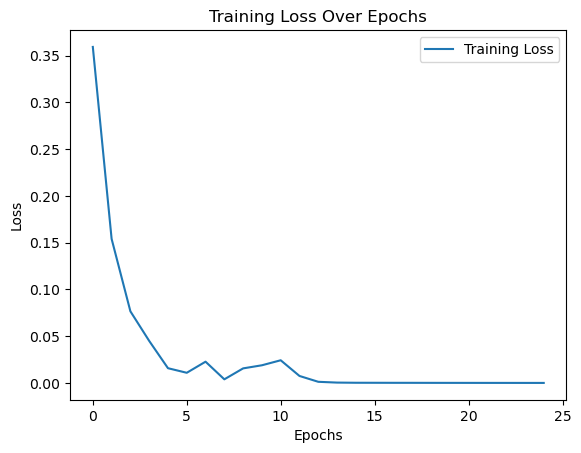

In [12]:
# Plotting the training loss
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

### Evulation 

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Switch to evaluation mode
model.eval()

predictions, true_labels = [], []

# Add tqdm progress bar
for batch in tqdm(dataloader, desc="Evaluating"):
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = outputs.logits
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    predictions.extend(batch_preds)
    true_labels.extend(label_ids)

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"Accuracy: {accuracy}")


Evaluating: 100%|██████████| 204/204 [00:16<00:00, 12.71it/s]

Accuracy: 1.0
